# AGT water level analysis

## Module import and configuration

In [7]:
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as plt_dates
import numpy as np
import os
import pandas as pd
pd.set_option('display.max_rows', 10)

The number of rows that are shown when a pandas dataframe is displayed is limited to keep an overview.  We also use magic to ensure that plots are shown inline in the notebook.

## Reading the data files

Read t8303 data from CSV file.  Skip the header information, skip the footer. The parser is not happy with the degrees character, so skip column headers, and assign our own.  Fortunately, the data for t8320 and u9117 is formatted similarly. To encapsulate all parameters, we wrap the `pd.read_csv` in a function.  However, the timestapms in for u9117 is different from that in the other files.  Hence the `read_senson_data` function has an optional timestamp format string.  The default is that for t8303 and t8320, while we call the function with a different version for u9117.

Note that reading the CSV data is quite fragile, and *will* break when the metadata format is modified.

In [8]:
def read_sensor_data(file_name, dt_fmt='%Y/%m/%d %H:%M:%S'):
    def dt_conv(dt):
        return datetime.strptime(dt, dt_fmt)
    return pd.read_csv(file_name, sep=';', skiprows=54,
                       skipfooter=1, engine='python',
                       names=['timestamp', 'pressure', 'temperature'],
                       converters={0: dt_conv})

In [9]:
t8303_data = read_sensor_data(os.path.join('agt_data', 'vei_t8303_160519102111_T8303.CSV'))
t8303_data

,timestamp,pressure,temperature
0,2016-03-23 12:00:00,1033.4,20.87
1,2016-03-23 12:05:00,1034.6,21.13
2,2016-03-23 12:10:00,1035.1,21.41
3,2016-03-23 12:15:00,1035.3,21.69
4,2016-03-23 12:20:00,1035.4,21.91
...,...,...,...
16380,2016-05-19 09:00:00,1031.0,13.95
16381,2016-05-19 09:05:00,1031.1,13.95
16382,2016-05-19 09:10:00,1031.1,13.95
16383,2016-05-19 09:15:00,1031.3,18.12


In [10]:
t8320_data = read_sensor_data(os.path.join('agt_data', 'vei_t8320_160519125721_T8320.CSV'))
t8320_data

,timestamp,pressure,temperature
0,2016-03-23 12:00:00,1033.3,21.22
1,2016-03-23 12:05:00,1034.2,21.53
2,2016-03-23 12:10:00,1034.9,21.87
3,2016-03-23 12:15:00,1035.2,22.20
4,2016-03-23 12:20:00,1035.2,22.42
...,...,...,...
16411,2016-05-19 11:35:00,1032.3,17.07
16412,2016-05-19 11:40:00,1032.4,17.07
16413,2016-05-19 11:45:00,1032.4,17.07
16414,2016-05-19 11:50:00,1032.4,17.07


In [11]:
u9117_data = read_sensor_data(os.path.join('agt_data', 'vei_u9117_p1.1_160519125431_U9117.CSV'),
                              dt_fmt='%d/%m/%Y %H:%M')
u9117_data

,timestamp,pressure,temperature
0,2016-03-23 12:00:00,1031.7,22.12
1,2016-03-23 12:05:00,1032.4,22.46
2,2016-03-23 12:10:00,1033.5,22.80
3,2016-03-23 12:15:00,1033.5,23.10
4,2016-03-23 12:20:00,1034.0,23.30
...,...,...,...
16410,2016-05-19 11:30:00,1313.6,12.54
16411,2016-05-19 11:35:00,1313.4,12.54
16412,2016-05-19 11:40:00,1313.6,12.55
16413,2016-05-19 11:45:00,1312.2,12.54


## Joining the data

The three dataframes share the same index, so they can be joined on that.  However, since these time series do not span the exact same period, this should be an outer join, rarther than the default inner join. The missing data points will be represented by `NaN`. A join in pandas is implemented in the `merge` operation, which works on two dataframes, hence we need an intermediate join for the first two dataframes, t8303 and t8320, and a second join on the result of the first, and u9117.

Note that since the dataframes have the same column names, we specify a meaningful suffix in order to distinguish those columns in the first join. This problem doesn't occur for the second join, but we rename the columns for u9117 so that all names are consistent. We do the latter in-place to conserve memory and gain efficiency.

In [12]:
tmp_data = pd.merge(t8303_data, t8320_data, how='outer', on='timestamp',
                    suffixes=('_t8303', '_t8320'))

In [13]:
sensor_data = pd.merge(tmp_data, u9117_data, how='outer', on='timestamp')
sensor_data.rename(columns={'pressure': 'pressure_u9117', 'temperature': 'temperature_u9117'},
                   inplace=True)

In [14]:
sensor_data

,timestamp,pressure_t8303,temperature_t8303,pressure_t8320,temperature_t8320,pressure_u9117,temperature_u9117
0,2016-03-23 12:00:00,1033.4,20.87,1033.3,21.22,1031.7,22.12
1,2016-03-23 12:05:00,1034.6,21.13,1034.2,21.53,1032.4,22.46
2,2016-03-23 12:10:00,1035.1,21.41,1034.9,21.87,1033.5,22.80
3,2016-03-23 12:15:00,1035.3,21.69,1035.2,22.20,1033.5,23.10
4,2016-03-23 12:20:00,1035.4,21.91,1035.2,22.42,1034.0,23.30
...,...,...,...,...,...,...,...
16411,2016-05-19 11:35:00,NaN,NaN,1032.3,17.07,1313.4,12.54
16412,2016-05-19 11:40:00,NaN,NaN,1032.4,17.07,1313.6,12.55
16413,2016-05-19 11:45:00,NaN,NaN,1032.4,17.07,1312.2,12.54
16414,2016-05-19 11:50:00,NaN,NaN,1032.4,17.07,1312.7,12.53


It is more convenient to have the timestamp as index, so we replace the default by the timestamp column.

In [15]:
sensor_data.set_index('timestamp', inplace=True)

If one of the air pressure sensor has no value for some timestamp, it can be substituted by the vallue of the other.  The same holds for the temperatures.

In [16]:
sensor_data['pressure_t8303'].fillna(sensor_data['pressure_t8320'], inplace=True)
sensor_data['pressure_t8320'].fillna(sensor_data['pressure_t8303'], inplace=True)
sensor_data['temperature_t8303'].fillna(sensor_data['temperature_t8320'], inplace=True)
sensor_data['temperature_t8320'].fillna(sensor_data['temperature_t8303'], inplace=True)

In [17]:
sensor_data

,pressure_t8303,temperature_t8303,pressure_t8320,temperature_t8320,pressure_u9117,temperature_u9117
timestamp,,,,,,
2016-03-23 12:00:00,1033.4,20.87,1033.3,21.22,1031.7,22.12
2016-03-23 12:05:00,1034.6,21.13,1034.2,21.53,1032.4,22.46
2016-03-23 12:10:00,1035.1,21.41,1034.9,21.87,1033.5,22.80
2016-03-23 12:15:00,1035.3,21.69,1035.2,22.20,1033.5,23.10
2016-03-23 12:20:00,1035.4,21.91,1035.2,22.42,1034.0,23.30
...,...,...,...,...,...,...
2016-05-19 11:35:00,1032.3,17.07,1032.3,17.07,1313.4,12.54
2016-05-19 11:40:00,1032.4,17.07,1032.4,17.07,1313.6,12.55
2016-05-19 11:45:00,1032.4,17.07,1032.4,17.07,1312.2,12.54


## Computation of derived columns

Now we add the derived columns `avg_baro_pressure`, `pressure_without_baro_u9117` and `water_level_u9117`.

In [18]:
depth_u9117 = 4.7735

In [19]:
sensor_data['avg_baro_pressure'] = (sensor_data['pressure_t8303'] + sensor_data['pressure_t8320'])/(2*100)
sensor_data['pressure_without_baro_u9117'] = sensor_data['pressure_u9117']/100.0 - sensor_data['avg_baro_pressure']
sensor_data['water_level_u9117'] = depth_u9117 - sensor_data['pressure_without_baro_u9117']

In [20]:
sensor_data

,pressure_t8303,temperature_t8303,pressure_t8320,temperature_t8320,pressure_u9117,temperature_u9117,avg_baro_pressure,pressure_without_baro_u9117,water_level_u9117
timestamp,,,,,,,,,
2016-03-23 12:00:00,1033.4,20.87,1033.3,21.22,1031.7,22.12,10.3335,-0.0165,4.7900
2016-03-23 12:05:00,1034.6,21.13,1034.2,21.53,1032.4,22.46,10.3440,-0.0200,4.7935
2016-03-23 12:10:00,1035.1,21.41,1034.9,21.87,1033.5,22.80,10.3500,-0.0150,4.7885
2016-03-23 12:15:00,1035.3,21.69,1035.2,22.20,1033.5,23.10,10.3525,-0.0175,4.7910
2016-03-23 12:20:00,1035.4,21.91,1035.2,22.42,1034.0,23.30,10.3530,-0.0130,4.7865
...,...,...,...,...,...,...,...,...,...
2016-05-19 11:35:00,1032.3,17.07,1032.3,17.07,1313.4,12.54,10.3230,2.8110,1.9625
2016-05-19 11:40:00,1032.4,17.07,1032.4,17.07,1313.6,12.55,10.3240,2.8120,1.9615
2016-05-19 11:45:00,1032.4,17.07,1032.4,17.07,1312.2,12.54,10.3240,2.7980,1.9755


## Plots in data_divers worksheet

Plot the waterlevel for u9117 as a function of time.

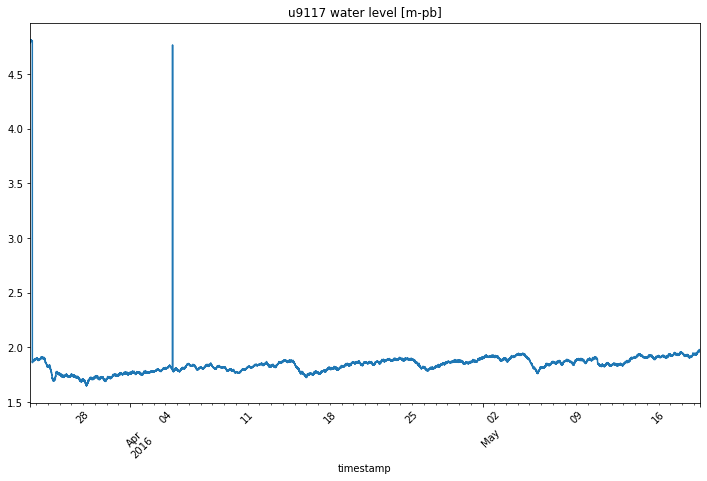

In [21]:
%matplotlib inline
sensor_data['water_level_u9117'].plot(title='u9117 water level [m-pb]',
                                      figsize=(12, 7), rot=45);

It is clear that there is an anomally in the data, filter out all data for which the water level exceeds 3.0, and plot again to verify.

In [22]:
sensor_data = sensor_data[sensor_data['water_level_u9117'] < 3.0].copy()

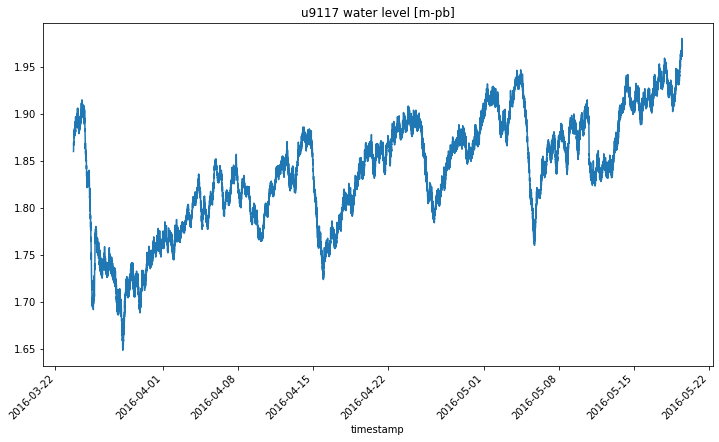

In [23]:
%matplotlib inline
sensor_data['water_level_u9117'].plot(title='u9117 water level [m-pb]',
                                      figsize=(12, 7), rot=45);

Plot the air pressure measured by t8303 and t8320 as a function of time.

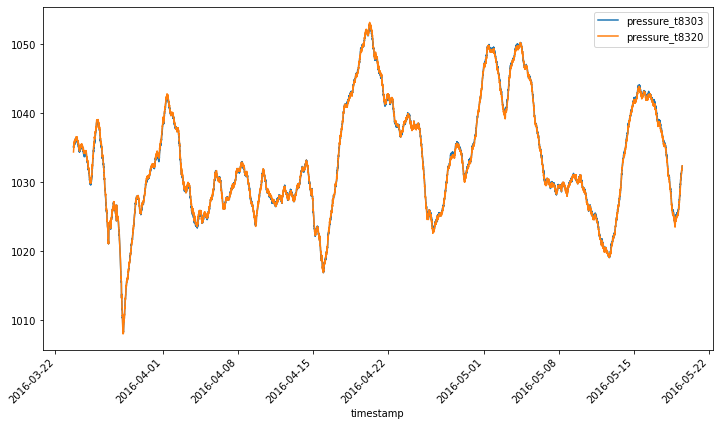

In [24]:
%matplotlib inline
sensor_data[['pressure_t8303', 'pressure_t8320']].plot(figsize=(12, 7), rot=45);

This data can also be presented differently to highlight deviations.

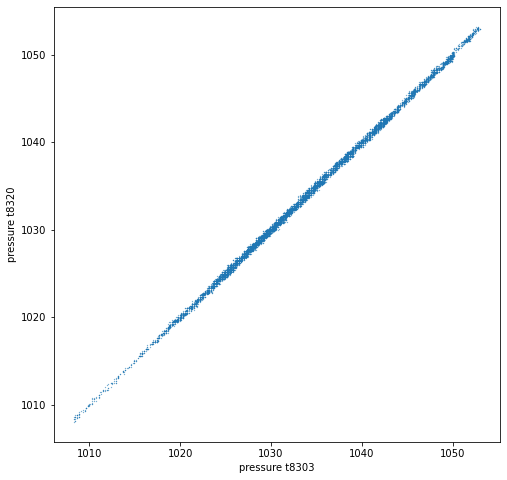

In [25]:
%matplotlib inline
plt.figure(figsize=(8.0, 8.0))
plt.plot(sensor_data['pressure_t8303'], sensor_data['pressure_t8320'],
         '.', markersize=0.5)
plt.xlabel('pressure t8303')
plt.ylabel('pressure t8320');

## Main plot

A few constants need to be defined before the actual water level can be computed.

In [26]:
z_field = 5.69
probe_level = 5.58

In [27]:
sensor_data['water_level_TAW'] = probe_level - sensor_data['water_level_u9117']
sensor_data['water_level_mv'] = z_field - sensor_data['water_level_TAW']

Since the `plot_date` function is totally brain dead, i.e., expecting a *number of days* since the start of the epoch as a floating point number, some arithmetic is required.

In [33]:
times = [plt_dates.datestr2num(str(date_time)) for date_time in sensor_data.index.tolist()]

The manual measurements should be defined as well.

In [35]:
manual_date_times = [
            '2016-03-23 16:22:00',
            '2016-04-04 15:49:00',
            '2016-05-19 12:52:00',
]
manual_times = [plt_dates.datestr2num(date_time) for date_time in manual_date_times]
manual_TAW = [3.72, 3.79, 3.61]
manual_mv = [1.97, 1.9, 2.08]

Now we can create the plot.

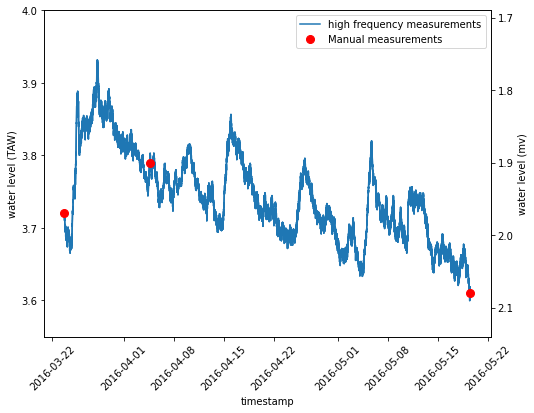

In [36]:
%matplotlib inline
figure, axes = plt.subplots()
figure.set_figwidth(8.0)
figure.set_figheight(6.0)
axes.set_ylim(3.55, 4.0)
axes.set_xlabel('timestamp')
axes.set_ylabel('water level (TAW)')
axes.plot_date(times, sensor_data['water_level_TAW'], '-')
axes.plot_date(manual_times, manual_TAW, 'ro')
axes2 = axes.twinx()
axes2.set_ylabel('water level (mv)')
axes2.set_ylim(z_field - 3.55, z_field - 4.0)
axes2.plot_date(times, sensor_data['water_level_mv'], '-', label='high frequency measurements')
axes2.plot_date(manual_times, manual_mv, 'ro', markersize=8, label='Manual measurements')
for tick_label in axes.get_xticklabels():
    tick_label.set_rotation(45)
axes2.legend(loc='upper right');

## Acknowledgement

Thanks to [A.G.T. n.v.](http://www.agt.be/) for making this data set available, and for the inspiration to create this notebook as a pandas example.